In [1]:
import numpy as np
import time
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from heapq import *
import networkx as nx
from collections import defaultdict

# Question 1

In [2]:
##create adj matrix for p-ER graph with K nodes and probabilty p
def p_ER(k, p):
    mat = np.zeros((k,k))
        
    for i in range(k):
        for j in range(i+1, k):
            add = np.random.binomial(1, p, 1)[0]
            if(add == 1):
                mat[i, j] = 1
                mat[j, i] = 1
    return mat

In [3]:
def r_regular(n, r):
    n_mat = np.zeros((n, n))

    try:
        nr_mat = np.zeros((n*r, n*r)) # Generate an N*RxN*R matrix which is to be considered as N groups of R elements
        block_n = list(range(n)) # Number of nodes
        
        # Create a list of tuples where the first element are the R rows in the matrix and the second element
        # contains the N groups which the R rows can connect to
        l = []
        for i in range(len(block_n)-1):
            l.append( ( list(range(block_n[i]*r, block_n[i+1]*r) ), list(set(block_n)-set([i])) ) )
        l.append( ( list(range(block_n[n-1]*r, len(nr_mat))),  list(set(block_n)-set([n-1])) ) )
        
        # Which of the N groups can still be connected
        usable_groups = list(range(n))
        
        check = 0 # Count number of edge creation
        while check != int(n*r/2):
            
            # Pick two random Nodes
            pick_n_big_1 = np.random.choice(list(set(usable_groups))) 
            pick_n_big_2 = np.random.choice( list( set(l[pick_n_big_1][1]).intersection(set(usable_groups)) ) )
            
            # Pick an edge
            pick_n_small_1 = np.random.choice( l[pick_n_big_1][0] )
            pick_n_small_2 = np.random.choice( l[pick_n_big_2][0] )        
            
            # Put the 1 inside the N*R matrix
            nr_mat[ l[pick_n_big_1][0][ np.where(l[pick_n_big_1][0] == pick_n_small_1)[0][0] ],
                    l[pick_n_big_2][0][ np.where(l[pick_n_big_2][0] == pick_n_small_2)[0][0] ] ] = 1
                   
            nr_mat[ l[pick_n_big_2][0][ np.where(l[pick_n_big_2][0] == pick_n_small_2)[0][0]],
                    l[pick_n_big_1][0][ np.where(l[pick_n_big_1][0] == pick_n_small_1)[0][0] ] ] = 1
            
            # Update the l list deleting the useless Nodes and Edges
            del l[pick_n_big_1][0][ np.where(l[pick_n_big_1][0] == pick_n_small_1)[0][0] ]
            del l[pick_n_big_2][0][ np.where(l[pick_n_big_2][0] == pick_n_small_2)[0][0] ]
            
            del l[pick_n_big_1][1][ np.where(l[pick_n_big_1][1] == pick_n_big_2)[0][0] ]
            del l[pick_n_big_2][1][ np.where(l[pick_n_big_2][1] == pick_n_big_1)[0][0] ]
            
            # If a node has ended the useful Edges delete that node from the usable_groups
            if( len(l[pick_n_big_1][0]) == 0 ):
                usable_groups = list(set(usable_groups) - set([pick_n_big_1]))

            if( len(l[pick_n_big_2][0]) == 0 ):
                usable_groups = list(set(usable_groups) - set([pick_n_big_2]))
            
            check += 1
        
        # Scan the N*R matrix and update the N*N matrix
        for i in range(n):
            for j in range(n):
                
                if( sum(sum(nr_mat[ r*i:r*(i+1), r*j:r*(j+1)])) == 1 ):
                    n_mat[i, j] = 1
                    n_mat[j, i] = 1

    except ValueError: # case in which nodes in usable_groups set are not in the list of connectible nodes of the picked node
        n_mat = r_regular(n, r)

    return n_mat

# Question 2

In [4]:
#compute connectivity using irreducibility
#we need to check that from the adj matrix A is true that
#I + A + A^2 + ... + A^n-1 >0

def is_irreducible(A):
    n = len(A)
    I = np.identity(n)
    Sum = I #start the sum with I
    A_new=A.copy()
    
    for i in range(1,n): 
        Sum += A_new #we ad A to the sum...
        A_new = np.inner(A_new, A) #...and update it
        
    if( np.min(Sum) > 0 ): # check if there are some 0s in the Sum matrix
        return True
    else:
        return False

In [5]:
#compute connectivity using laplacian method
#we pass the graph in input as a adj matrix A

def L_method(A):
    #we need to compute the laplacian matrix as L=D-A
    #where D is a diagonal matrix having the sum of rows of A
    D = np.diag(sum(A)) 
    L = D - A
    
    if( np.sort(np.linalg.eigvals(L))[1] > 0): #check if eigenvalues are non negative
        return True
    else:
        return False

In [6]:
def BFS(g, root=0):
    
    # Initialize starting point
    queue = [root]
    visited = [root]

    
    # Explore the graph
    while len(queue) != 0:
        
        # Enters inside the first node of the queue and updates it
        current_node = queue[0]
        del queue[0]        
        
        # Which nodes are connected with current_node
        visiting = list(np.where(g[current_node,:] == 1)[0])
        
        # Update visited and queue list
        for node in visiting:
            if(node not in visited):
                visited.append(node)
                queue.append(node)
    
    if( len(visited) == len(g) ):
        return True
    else:
        return False

In [7]:
#set the parameters and build some graph to work on 

k=100
p=8/(k-1)
r=8

A_r = r_regular(k, r)
A_p = p_ER(k, p)

C:\Users\giuli\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


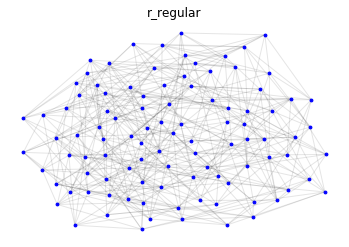

In [8]:
## let'see how the graph looks like

G_r = nx.from_numpy_matrix(A_r)

# create the layout
pos = nx.spring_layout(G_r)
# draw the nodes and the edges
nx.draw_networkx_nodes(G_r,pos,node_color='b',node_size=8)
nx.draw_networkx_edges(G_r,pos,alpha=0.1)
plt.title("r_regular")
plt.axis('off')
plt.show()

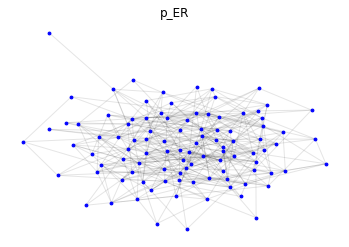

In [9]:
G_p = nx.from_numpy_matrix(A_p)

# create the layout
pos = nx.spring_layout(G_p)
# draw the nodes and the edges
nx.draw_networkx_nodes(G_p,pos,node_color='b',node_size=8)
nx.draw_networkx_edges(G_p,pos,alpha=0.1)
plt.title("p_ER")
plt.axis('off')
plt.show()

# Question 3

In [10]:
# Vector of different K
n_vect = [50, 75, 100, 125, 150, 175, 200]

d_r = {}
for n in n_vect:
    d_r[n] = []
    
    # Generate an r_regular adjacency matrix
    A_r = r_regular(n, r)
    
    # Tests irreducibility method
    start = time.time()
    is_irreducible(A_r)
    d_r[n].append( time.time() - start )
    
    # Tests Laplacian eigenvalue method
    start = time.time()
    L_method(A_r)
    d_r[n].append( time.time() - start )
    
    # Tests BFS method
    start = time.time()
    BFS(A_r)
    d_r[n].append( time.time() - start )

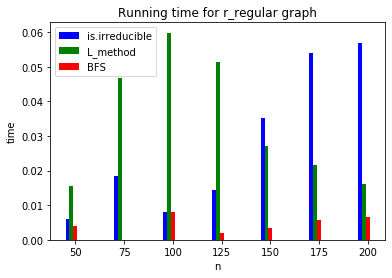

In [11]:
# Plot of the running time taken for the three different methods r_regular
colors = ['b', 'g', 'r']  
x, y = zip(*sorted(d_r.items(), key = lambda x: x[0]))

plt.figure()
for i in range(3):
    x = list(x)
    lst = []
    for h in range(len(y)):
        lst.append(y[h][i])
    
    for j in range(len(x)):
        x[j] = x[j]+2
        
    plt.bar(list(x), lst, color = colors[i], lw = 2, width = 2)
plt.legend(['is.irreducible', 'L_method', 'BFS'], loc = 2)
plt.title('Running time for r_regular graph')
plt.xlabel('n')
plt.ylabel('time')
plt.xticks(x, n_vect)
plt.show()

let's do the same but on ER graphs

In [12]:
n_vect = [50, 75, 100, 125, 150, 175, 200]
d_p = {}
p=0.5
for n in range(20,200,20):
    d_p[n] = []
    
    # Generate an r_regulare adjacency matrix
    A_p = p_ER(n, p)
    
    # Tests irreducibility method
    start = time.time()
    is_irreducible(A_p)
    d_p[n].append( time.time() - start )
    
    # Tests Laplacian eigenvalue method
    start = time.time()
    L_method(A_p)
    d_p[n].append( time.time() - start )
    
    # Tests BFS method
    start = time.time()
    BFS(A_p)
    d_p[n].append( time.time() - start )

C:\Users\giuli\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in add
  if sys.path[0] == '':


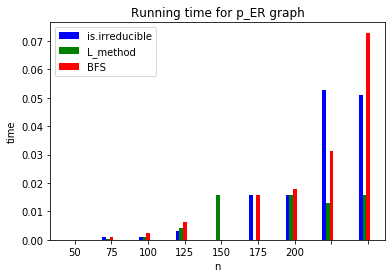

In [13]:
# Plot of the running time taken for the three different methods for p_ER
colors = ['b', 'g', 'r']  
z, k = zip(*sorted(d_p.items(), key = lambda x: x[0]))

plt.figure()
for i in range(3):
    z = list(z)
    lst = []
    for h in range(len(k)):
        lst.append(k[h][i])
    
    for j in range(len(z)):
        z[j] = z[j]+2
        
    plt.bar(list(z), lst, color = colors[i], lw = 2, width = 2)
plt.legend(['is.irreducible', 'L_method', 'BFS'], loc = 2)
plt.title('Running time for p_ER graph')
plt.xlabel('n')
plt.ylabel('time')
plt.xticks(z, n_vect)
plt.show()

# Question 4

In [14]:
# Probability for a p_ER graph
rep = 100
p_vect = [i/100 for i in range(0,11)]
p_vect = p_vect + [i/10 for i in range(2,11)]
percent = []
for p in p_vect:
    count_p = 0
    for i in range(rep):
        
        A_p = p_ER(n, p)
        
        x= L_method(A_p)
        
        if  x  : #check if the graph is connected via L method
            count_p += 1
    percent.append(count_p)

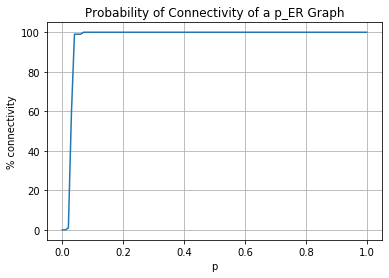

In [15]:
plt.plot(p_vect,percent)
plt.title('Probability of Connectivity of a p_ER Graph')
plt.xlabel('p')
plt.ylabel('% connectivity')
plt.grid()
plt.show()

let's now do the MC simulation for r regular graph

In [16]:
r_vect = [2, 8]
n_vect = [i*10 for i in range(1,11)]
k2=[]
percent2=[]
k8=[]
percent8=[]
for r in r_vect:
    for n in n_vect:
        count = 0
        for i in range(rep):
            
            A_r = r_regular(n, r)
            
            x = BFS(A_r)
            
            if x:
                count += 1
        if r==2:
            k2.append(n)
            percent2.append(count)
        else:
            k8.append(n)
            percent8.append(count)

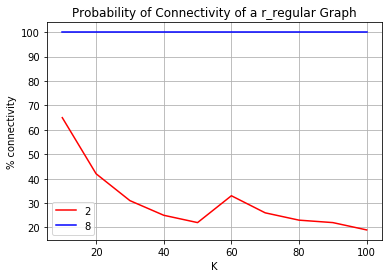

In [17]:
plt.plot(k2, percent2, color='r')
plt.plot(k8, percent8, color='b')
plt.title('Probability of Connectivity of a r_regular Graph')
plt.xlabel('K')
plt.ylabel('% connectivity')
plt.legend(r_vect)
plt.grid()
plt.show()

## Part 2

### Question 1

We know that for fat tree $S_{ft} = \frac{5n^{2}}{4}$

we also know that $N_{jf}=S_{jf}(n-r)$ and that $S_{ft}$ must be equal to $S_{jf}$

and finally, we know that $N_{jf}$ must be equal to $N_{ft}=\frac{n^{3}}{4}$

from this we can find $r$ as a function of $n$ :


$\frac{5n^{2}(n-r)}{4}=\frac{n^{3}}{4}$  

$\Rightarrow 5(n-r)=n$

$\Rightarrow r=\frac{4n}{5} $ 

In [18]:
###find r as function of n so that fat tree and jellifish has same S L and N

##since S in fat tree is == 4/5*(n^2), this will be the same in jellifish
##since N in jellifish is == S(n-r) we find that...
### if r=(4/5)*n

def find_r(n):
    return(4/5*n)

### Question 2

We know that the number of flows is

$n_{f}=\frac{N(N-1)}{2}$

where $N=\frac{n^{3}}{4}$

we also know that $TH= \frac{L}{\overline{h}n_{f}}$ , where $L=3N$

so we find that $TH=\frac{3N}{\overline{h}\frac{N(N-1)}{2}}$

$=\frac{6}{\overline{h}(N-1)}$

$=\frac{6}{\overline{h}(\frac{n^{3}}{4}-1)}$

### Question 3